# A U-Net to make t2w images from t1w images

RT, February 2020

In [2]:
#!pip install tensorflow

In [3]:
import tensorflow as tf
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import PIL
from tensorflow.keras.layers import Activation, BatchNormalization, concatenate, Conv2D, Conv2DTranspose, LeakyReLU

In [4]:
# Constants
BUFFER_SIZE = 400
BATCH_SIZE = 20
IMG_WIDTH = 128
IMG_HEIGHT = 128
EPOCHS = 300

### 1. Prepare data

#### T1W and T2W data

In [5]:
# Image preprocessing and data augmentation
PATH = os.path.join(os.path.abspath('.'), 't1t2/')
OUTPUT_CHANNELS = 3
def load_image(image_file, is_train):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    w = tf.shape(image)[1]
    w = w // 2
    real_image = image[:, :w, :]
    input_image = image[:, w:, :]
    real_image = tf.cast(real_image, tf.float32)
    input_image = tf.cast(input_image, tf.float32)

    # normalizing the images to [0, 1]
    input_image = input_image / 255
    real_image = real_image / 255

    return real_image, input_image

# Create train and test dataset batches
train_dataset = tf.data.Dataset.list_files(PATH+'train/*.jpg')
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.map(lambda x: load_image(x, True))
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.repeat()

test_dataset = tf.data.Dataset.list_files(PATH+'test/*.jpg')
test_dataset = test_dataset.map(lambda x: load_image(x, False))
test_dataset = test_dataset.batch(BATCH_SIZE)

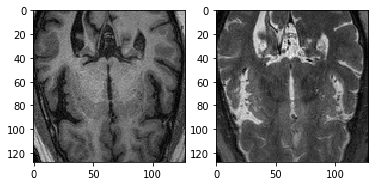

In [6]:
iterator = iter(train_dataset)
el = iterator.get_next()
(a,b) = el
plt.subplot(121); plt.imshow(a[0])
plt.subplot(122); plt.imshow(b[0])

### 2. Build the network

In [7]:
# input
initializer = tf.random_normal_initializer(0., 0.02)
inputs = tf.keras.layers.Input(shape=(IMG_WIDTH,IMG_HEIGHT,OUTPUT_CHANNELS,))

# downsample path
x = Conv2D(32,(3,3),strides=2,padding='same',kernel_initializer=initializer,use_bias=False,name="d1")(inputs)
#x = BatchNormalization()(x)
x1 = LeakyReLU()(x)

x = Conv2D(64,(3,3),strides=2,padding='same',kernel_initializer=initializer,use_bias=False,name="d2")(x1)
x = BatchNormalization()(x)
x2 = LeakyReLU()(x)

x = Conv2D(128,(3,3),strides=2,padding='same',kernel_initializer=initializer,use_bias=False,name="d3")(x2)
x = BatchNormalization()(x)
x3 = LeakyReLU()(x)

x = Conv2D(128,(3,3),strides=2,padding='same',kernel_initializer=initializer,use_bias=False,name="d4")(x3)
x = BatchNormalization()(x)
x4 = LeakyReLU()(x)

# upsample path
x5 = Conv2DTranspose(128,(3,3),strides=2,padding='same',kernel_initializer=initializer,use_bias=False,name="u1")(x4)
x5 = BatchNormalization()(x5)
x5 = Activation('relu')(x5)
x5 = concatenate([x5, x3],axis=-1)

x6 = Conv2DTranspose(64,(3,3),strides=2,padding='same',kernel_initializer=initializer,use_bias=False,name="u2")(x5)
x6 = BatchNormalization()(x6)
x6 = Activation('relu')(x6)
x6 = concatenate([x6, x2],axis=-1)

x7 = Conv2DTranspose(32,(3,3),strides=2,padding='same',kernel_initializer=initializer,use_bias=False,name="u3")(x6)
x7 = BatchNormalization()(x7)
x7 = Activation('relu')(x7)
x7 = concatenate([x7, x1],axis=-1)

# output
x8 = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS,(3, 3),strides=2,padding='same',kernel_initializer=initializer,name="u8")(x7)
x8 = tf.keras.layers.Activation('sigmoid')(x8)

unet = tf.keras.Model(inputs, x8)
unet_optimizer = tf.optimizers.Adam(learning_rate=0.001)
unet.compile(optimizer=unet_optimizer, loss='binary_crossentropy')

In [8]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
d1 (Conv2D)                     (None, 64, 64, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 64, 64, 32)   0           d1[0][0]                         
__________________________________________________________________________________________________
d2 (Conv2D)                     (None, 32, 32, 64)   18432       leaky_re_lu[0][0]                
______________________________________________________________________________________________

### 3. Train

In [40]:
# fit
unet.fit(train_dataset, steps_per_epoch=400, epochs=EPOCHS)

Train for 400 steps
Epoch 1/300
400/400 [==============================] - 71s 177ms/step - loss: 0.4413
Epoch 2/300
400/400 [==============================] - 69s 174ms/step - loss: 0.4391
Epoch 3/300
400/400 [==============================] - 69s 173ms/step - loss: 0.4404
Epoch 4/300
400/400 [==============================] - 70s 174ms/step - loss: 0.4393
Epoch 5/300
400/400 [==============================] - 70s 174ms/step - loss: 0.4414
Epoch 6/300
400/400 [==============================] - 71s 176ms/step - loss: 0.4410
Epoch 7/300
400/400 [==============================] - 69s 172ms/step - loss: 0.4396
Epoch 8/300
400/400 [==============================] - 70s 175ms/step - loss: 0.4389
Epoch 9/300
400/400 [==============================] - 71s 176ms/step - loss: 0.4427
Epoch 10/300
400/400 [==============================] - 71s 177ms/step - loss: 0.4382
Epoch 11/300
400/400 [==============================] - 69s 174ms/step - loss: 0.4415
Epoch 12/300
400/400 [=====================

400/400 [==============================] - 70s 175ms/step - loss: 0.4387
Epoch 97/300
400/400 [==============================] - 71s 178ms/step - loss: 0.4414
Epoch 98/300
400/400 [==============================] - 70s 175ms/step - loss: 0.4374
Epoch 99/300
400/400 [==============================] - 70s 175ms/step - loss: 0.4393
Epoch 100/300
400/400 [==============================] - 70s 175ms/step - loss: 0.4384
Epoch 101/300
400/400 [==============================] - 70s 176ms/step - loss: 0.4381
Epoch 102/300
400/400 [==============================] - 69s 173ms/step - loss: 0.4379
Epoch 103/300
400/400 [==============================] - 69s 173ms/step - loss: 0.4401
Epoch 104/300
400/400 [==============================] - 69s 171ms/step - loss: 0.4396
Epoch 105/300
400/400 [==============================] - 69s 172ms/step - loss: 0.4370
Epoch 106/300
400/400 [==============================] - 68s 170ms/step - loss: 0.4403
Epoch 107/300
400/400 [==============================] - 69s

400/400 [==============================] - 67s 168ms/step - loss: 0.4381
Epoch 285/300
400/400 [==============================] - 65s 164ms/step - loss: 0.4366
Epoch 286/300
400/400 [==============================] - 66s 166ms/step - loss: 0.4379
Epoch 287/300
400/400 [==============================] - 66s 165ms/step - loss: 0.4388
Epoch 288/300
400/400 [==============================] - 65s 163ms/step - loss: 0.4390
Epoch 289/300
400/400 [==============================] - 65s 163ms/step - loss: 0.4368
Epoch 290/300
400/400 [==============================] - 67s 167ms/step - loss: 0.4393
Epoch 291/300
400/400 [==============================] - 66s 166ms/step - loss: 0.4369
Epoch 292/300
400/400 [==============================] - 67s 168ms/step - loss: 0.4391
Epoch 293/300
400/400 [==============================] - 67s 168ms/step - loss: 0.4371
Epoch 294/300
400/400 [==============================] - 68s 169ms/step - loss: 0.4383
Epoch 295/300
400/400 [==============================] - 

### 4. Predict

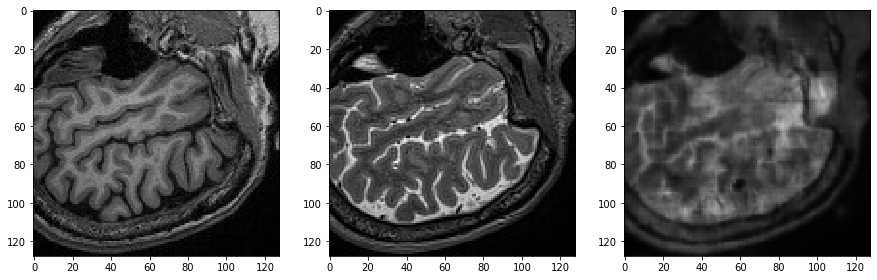

In [51]:
iterator = iter(test_dataset)
el = iterator.get_next()
(a,b) = el
output = unet.predict(b, steps=1)
plt.figure(figsize=(15,15))
plt.subplot(131); plt.imshow(a[0])
plt.subplot(132); plt.imshow(b[0])
plt.subplot(133); plt.imshow(output[0])

## 5. Save

In [52]:
checkpoint_path = "./t1t2/cp-{epoch:04d}.ckpt"
unet.save_weights(checkpoint_path.format(epoch=500))

In [53]:
!open .